![header](../figures/logos_partenaires._cmems_se.jpg)

# Benchmark DUACS geostrophic currents maps

<div style="text-align: right"><i> 2023-04-27 MIOST_UV_BENCHMARK_DEMO </i></div>

***
**Authors:**  CLS & Datlas <br>
**Copyright:** 2023 CLS & Datlas <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h1><center>Benchmark of DUACS geostrophic currents maps</center></h1>
 <h5> The notebook aims to evaluate the surface current maps produced by the DUACS system.</h5>
    <h5> These maps are equivalent to the SEALEVEL_GLO_PHY_L4_MY_008_047 product distributed by the Copernicus Marine Service, except that a nadir altimeter (SARAL/Altika, SEALEVEL_GLO_PHY_L3_MY_008_062 product) has been excluded from the mapping. </h5>
        <h5> We provide below a demonstration of the validation of these maps against the current data from the drifters database distributed by CMEMS (INSITU_GLO_PHY_UV_DISCRETE_MY_013_044 product) </h5>
</div>

***
**General Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**General Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
***


<div class="alert alert-danger" role="alert">

<h3>Learning outcomes</h3>

At the end of this notebook you will know:
<ul>
  <li>How you can evaluated Sea surface currents maps with drifters database: statistical and spectral analysis</li>
</ul>
    
</div>

In [1]:
from glob import glob
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.append('..')
from src.mod_plot import *
from src.mod_stat import *
from src.mod_spectral import *
from src.mod_interp import *

In [3]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

<div class="alert alert-info" role="alert">

<h2>0. Parameters</h2>

</div>

In [4]:
time_min = '2019-01-01'                                        # time min for analysis
time_max = '2019-12-31'                                        # time max for analysis
output_dir = '../results'                                      # output directory path
os.system(f'mkdir -p {output_dir}')
method_name='DUACS'
stat_output_filename = f'{output_dir}/stat_uv_duacs_geos.nc'   # output statistical analysis filename
psd_output_filename = f'{output_dir}/psd_uv_duacs_geos.nc'     # output spectral analysis filename
segment_lenght = np.timedelta64(40, 'D')                      # spectral parameter: drifters segment lenght in days to consider in the spectral analysis

<div class="alert alert-info" role="alert">

<h2>1. Input files</h2>

</div>

## [Sea Surface currents from Drifters database](https://doi.org/10.17882/86236)

In [5]:
filenames_drifters = sorted(glob('../data/independent_drifters/uv_drifters_*.nc'))

In [6]:
ds_drifter = xr.open_mfdataset(filenames_drifters, combine='nested', concat_dim='time')
ds_drifter = ds_drifter.where((ds_drifter.time >= np.datetime64(time_min)) & (ds_drifter.time <=  np.datetime64(time_max)), drop=True)
ds_drifter

<xarray.Dataset>
Dimensions:    (time: 2156405)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01 ... 2019-12-31
    latitude   (time) float32 dask.array<chunksize=(5559,), meta=np.ndarray>
    longitude  (time) float32 dask.array<chunksize=(5559,), meta=np.ndarray>
Data variables:
    EWCT       (time) float32 dask.array<chunksize=(5559,), meta=np.ndarray>
    NSCT       (time) float32 dask.array<chunksize=(5559,), meta=np.ndarray>
    sensor_id  (time) float64 dask.array<chunksize=(5559,), meta=np.ndarray>
Attributes: (12/46)
    data_type:                   OceanSITES trajectory data
    format_version:              2.0
    platform_code:               116275
    date_update:                 2020-10-13T12:17:40Z
    institution:                 AOML
    institution_edmo_code:       1799
    ...                          ...
    deployment_lat:              -58.44
    last_longitude_observation:  82.75
    last_latitude_observation:   -18.49
    date_drog_lost:              2017-01-21T03:37:00Z
    death_type:                  stop transmitting
    last_date_observation:       2019-01-16T01:51:00Z

## Sea Surface current maps to evaluate

In [7]:
list_of_maps = sorted(glob('../data/maps/DUACS_global_allsat-alg/*.nc'))
ds_maps = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time')
ds_maps = ds_maps.sel(time=slice(time_min, time_max))
ds_maps

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, time: 365)
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float64 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time       (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-12-31
Data variables:
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>

<div class="alert alert-info" role="alert">

<h2>2. Statistical & Spectral Analysis </h2>

</div>

## 2.1 Interpolate sea surface currents maps onto drifters positions

In [8]:
ds_interp = run_interpolation_drifters(ds_maps, ds_drifter, time_min, time_max)
ds_interp = ds_interp.dropna('time')
ds_interp = ds_interp.sortby('time')
ds_interp

2025-03-07 15:50:12 INFO     fetch data from 2019-01-01 00:00:00 to 2019-02-01 00:00:00
2025-03-07 15:51:22 INFO     fetch data from 2019-01-01 00:00:00 to 2019-02-01 00:00:00
2025-03-07 15:52:35 INFO     fetch data from 2019-01-31 00:00:00 to 2019-03-01 00:00:00
2025-03-07 15:53:40 INFO     fetch data from 2019-01-31 00:00:00 to 2019-03-01 00:00:00
2025-03-07 15:54:46 INFO     fetch data from 2019-02-28 00:00:00 to 2019-04-01 00:00:00
2025-03-07 15:56:07 INFO     fetch data from 2019-02-28 00:00:00 to 2019-04-01 00:00:00
2025-03-07 15:57:26 INFO     fetch data from 2019-03-31 00:00:00 to 2019-05-01 00:00:00
2025-03-07 15:58:27 INFO     fetch data from 2019-03-31 00:00:00 to 2019-05-01 00:00:00
2025-03-07 15:59:33 INFO     fetch data from 2019-04-30 00:00:00 to 2019-06-01 00:00:00
2025-03-07 16:00:37 INFO     fetch data from 2019-04-30 00:00:00 to 2019-06-01 00:00:00
2025-03-07 16:01:42 INFO     fetch data from 2019-05-31 00:00:00 to 2019-07-01 00:00:00
2025-03-07 16:02:43 INFO     fet

<xarray.Dataset>
Dimensions:            (time: 2113855)
Coordinates:
  * time               (time) datetime64[ns] 2019-01-01 ... 2019-12-31
Data variables:
    EWCT               (time) float32 -0.1013 -0.1692 ... -0.04298 -0.07795
    NSCT               (time) float32 0.2415 0.00305 ... 0.03121 -0.1021
    sensor_id          (time) float64 1.163e+05 1.164e+05 ... 6.831e+07
    latitude           (time) float32 -20.17 -23.35 -29.47 ... -16.64 -32.11
    longitude          (time) float32 87.07 -6.986 -12.2 ... 86.61 121.6 95.08
    ugos_interpolated  (time) float64 -0.1084 0.01123 ... -0.0377 -0.06921
    vgos_interpolated  (time) float64 0.1425 -0.09121 ... 0.2766 0.001184

## 2.2 Compute grid boxes statistics & statistics by regime (coastal, offshore low variability, offshore high variability)

Once the surface currents maps have been interpolated to the position of the drifters, it is possible to calculate different statistics on the time series of zonal and meridional velocities. 

We propose below the following statistics: error variance maps (static by 1°x1° box), explained variance maps. 

In [9]:
# Compute gridded stats
compute_stat_scores_uv(ds_interp, stat_output_filename,method_name=method_name)

2025-03-07 16:18:04 INFO     Compute mapping error all scales
2025-03-07 16:18:04 INFO     Compute statistics
2025-03-07 16:18:16 INFO     Stat file saved as: ../results/stat_uv_duacs_geos.nc
2025-03-07 16:18:16 INFO     Compute statistics by oceanic regime


In [10]:


def plot_stat_score_map_uv_png(filename,region='glob',box_lonlat=None):

    ds_binning_allscale = xr.open_dataset(filename, group='all_scale')
    
    
    if box_lonlat is not None:
        lon_min = box_lonlat['lon_min']
        lon_max = box_lonlat['lon_max']
        lat_min = box_lonlat['lat_min']
        lat_max = box_lonlat['lat_max']
        ds_binning_allscale = ds_binning_allscale.sel({'lon':slice(lon_min,lon_max),'lat':slice(lat_min,lat_max)}) 
    
    
    
    try : 
        method_name = ds_binning_allscale.attrs['method']
    except:
        method_name = ''
        
    
    fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,7.5))

    axs=axs.flatten()
    
    vmin = 0.
    vmax= 0.1
    p0 = axs[0].pcolormesh(ds_binning_allscale.lon, ds_binning_allscale.lat, ds_binning_allscale.variance_mapping_err_u, vmin=vmin, vmax=vmax, cmap='Reds')
    axs[0].set_title('Zonal current [All scale]')
    axs[0].coastlines(resolution='10m', lw=0.5)
    # optional add grid lines
    p0.axes.gridlines(color='black', alpha=0., linestyle='--')
    # draw parallels/meridiens and write labels
    gl = p0.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.1, color='black', alpha=0.5, linestyle='--')
    # adjust labels to taste
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabels_bottom = False
    gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    
    p1 = axs[1].pcolormesh(ds_binning_allscale.lon, ds_binning_allscale.lat, ds_binning_allscale.variance_mapping_err_v, vmin=vmin, vmax=vmax, cmap='Reds')
    axs[1].set_title('Meridional current [All scale]')
    axs[1].coastlines(resolution='10m', lw=0.5)
    # optional add grid lines
    p1.axes.gridlines(color='black', alpha=0., linestyle='--')
    # draw parallels/meridiens and write labels
    gl = p1.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.1, color='black', alpha=0.5, linestyle='--')
    # adjust labels to taste
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylabels_left = False
    gl.xlabels_bottom = False
    gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    
    cax = fig.add_axes([0.92, 0.37, 0.02, 0.25])
    cbar = fig.colorbar(p1, cax=cax, orientation='vertical')
    cax.set_ylabel('Error variance [m$^2$.s$^{-2}$]', fontweight='bold')
    
    plt.savefig("../figures/Maps_"+str(method_name)+"_errvar_"+region+"_uv.png", bbox_inches='tight')
    
    fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.01) 
    
    fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,7.5))

    axs=axs.flatten()
    
    vmin = 0.
    vmax= 1
    p2 = axs[0].pcolormesh(ds_binning_allscale.lon, ds_binning_allscale.lat, (1 - ds_binning_allscale['variance_mapping_err_u']/ds_binning_allscale['variance_drifter_u']), vmin=vmin, vmax=vmax, cmap='RdYlGn')
    axs[0].set_title('Zonal current [All scale]')
    axs[0].coastlines(resolution='10m', lw=0.5)
    # optional add grid lines
    p2.axes.gridlines(color='black', alpha=0., linestyle='--')
    # draw parallels/meridiens and write labels
    gl = p2.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.1, color='black', alpha=0.5, linestyle='--')
    # adjust labels to taste
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    
    
    p3 = axs[1].pcolormesh(ds_binning_allscale.lon, ds_binning_allscale.lat, (1 - ds_binning_allscale['variance_mapping_err_v']/ds_binning_allscale['variance_drifter_v']), vmin=vmin, vmax=vmax, cmap='RdYlGn')
    axs[1].set_title('Meridional current [All scale]')
    axs[1].coastlines(resolution='10m', lw=0.5)
    # optional add grid lines
    p3.axes.gridlines(color='black', alpha=0., linestyle='--')
    # draw parallels/meridiens and write labels
    gl = p3.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.1, color='black', alpha=0.5, linestyle='--')
    # adjust labels to taste
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.ylabels_right = False
    gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    
    cax = fig.add_axes([0.92, 0.42, 0.02, 0.25])
    fig.colorbar(p3, cax=cax, orientation='vertical')
    cax.set_ylabel('Explained variance', fontweight='bold')
    
    
    fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.01) 
    
    plt.savefig("../figures/Maps_"+str(method_name)+"_explvar_"+region+"_uv.png", bbox_inches='tight')
    

ValueError: NumPy boolean array indexing assignment cannot assign 105 input values to the 180 output values where the mask is true

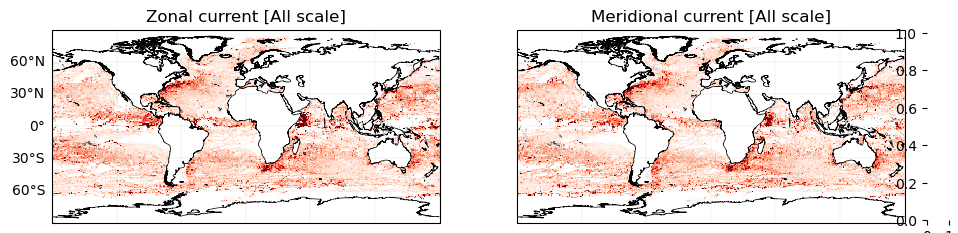

In [11]:
# Plot gridded stats
# Hvplot
# plot_stat_score_map_uv(stat_output_filename)
# Matplotlib
plot_stat_score_map_uv_png(stat_output_filename)

The figure shows that the maximum mapping errors are found in intense current systems, for example in the GulfStream, Kuroshio and Agulhas regions. 

However, when considering the full scale of motion in the drifter database, the surface current maps capture up to 80% of the variability of drifter currents in the Western Boundary Currents and Antarctic Circumpolar Currents (ACC). The geostrophic signal dominates the ageostrophic signal in these regions. In regions with low ocean variability, only a few percent of the total drifter current variability is recovered in the maps, which may be associated with a larger ageostrophic signal in these regions.

In [12]:
plot_stat_uv_by_regimes(stat_output_filename)

,mapping_err_u_var [m²/s²],mapping_err_v_var [m²/s²],ugos_interpolated_var [m²/s²],EWCT_var [m²/s²],vgos_interpolated_var [m²/s²],NSCT_var [m²/s²],var_score_u_allscale,var_score_v_allscale
coastal,0.028590,0.023592,0.023698,0.055470,0.022957,0.045955,0.484590,0.486621
offshore_highvar,0.038773,0.038820,0.101132,0.139475,0.093323,0.121805,0.722010,0.681292
offshore_lowvar,0.023837,0.018906,0.017314,0.043423,0.013135,0.030951,0.451046,0.389165
equatorial_band,0.049079,0.033805,0.057707,0.106850,0.028334,0.057675,0.540670,0.413874
arctic,0.014592,0.014522,0.003463,0.018806,0.004674,0.019806,0.224055,0.266796
antarctic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2.4 Compute Spectral scores

In [13]:
# Compute PSD scores
compute_psd_scores_current(ds_interp, psd_output_filename, lenght_scale=segment_lenght,method_name=method_name)

2025-03-07 16:19:53 INFO     Segment computation...
2025-03-07 16:23:13 INFO     Spectral analysis...
2025-03-07 16:23:14 INFO     Write output...
2025-03-07 16:23:14 INFO     PSD file saved as: ../results/psd_uv_duacs_geos.nc


In [ ]:
# Plot Zonally averaged rotary spectra
# Hvplot
# plot_psd_scores_currents(psd_output_filename)
# Matplotlib
plot_psd_scores_currents_png(psd_output_filename)

In [ ]:
# Plot Zonally averaged rotary spectra
plot_psd_scores_currents_1D(psd_output_filename)

The interactive plot above allows you to explore the spectral metrics by latitude band